In [ ]:
import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
from torchsummary import summary
import time
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torchvision import models

In [ ]:
torch.cuda.empty_cache()

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
    ])

In [ ]:
BATCH_SIZE = 256
learning_rate = 0.001
EPOCHS = 7
numClasses = 43  

In [ ]:
train_data_path = '/content/drive/MyDrive/Datasets/ML/train'
train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = data_transforms)

# Divide data into training and validation (0.8 and 0.2)
ratio = 0.8
n_train_examples = int(len(train_data) * ratio)
n_val_examples = len(train_data) - n_train_examples

train_data, val_data = data.random_split(train_data, [n_train_examples, n_val_examples])

print(f"Number of training samples = {len(train_data)}")
print(f"Number of validation samples = {len(val_data)}")

Number of training samples = 31374
Number of validation samples = 7844


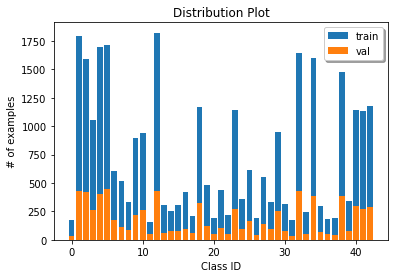

In [ ]:
train_hist = [0]*numClasses
for i in train_data.indices:
    tar = train_data.dataset.targets[i]
    train_hist[tar] += 1
    
val_hist = [0]*numClasses
for i in val_data.indices:
    tar = val_data.dataset.targets[i]
    val_hist[tar] += 1

plt.bar(range(numClasses), train_hist, label="train")
plt.bar(range(numClasses), val_hist, label="val")
legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

plt.savefig("train_val_split.png", bbox_inches = 'tight', pad_inches=0.5)

In [ ]:
train_loader = data.DataLoader(train_data, shuffle=True, batch_size = BATCH_SIZE)
val_loader = data.DataLoader(val_data, shuffle=True, batch_size = BATCH_SIZE)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
model = models.vgg16_bn()
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 138,365,992 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
criterion = criterion.to(device)

cpu


In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
print(summary(model, (3, 112, 112)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,792
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          36,928
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              ReLU-6         [-1, 64, 112, 112]               0
         MaxPool2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]          73,856
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]         147,584
      BatchNorm2d-12          [-1, 128, 56, 56]             256
             ReLU-13          [-1, 128, 56, 56]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
print("Model's state dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print("")

Model's state dict:
features.0.weight 	 torch.Size([64, 3, 3, 3])
features.0.bias 	 torch.Size([64])
features.1.weight 	 torch.Size([64])
features.1.bias 	 torch.Size([64])
features.1.running_mean 	 torch.Size([64])
features.1.running_var 	 torch.Size([64])
features.1.num_batches_tracked 	 torch.Size([])
features.3.weight 	 torch.Size([64, 64, 3, 3])
features.3.bias 	 torch.Size([64])
features.4.weight 	 torch.Size([64])
features.4.bias 	 torch.Size([64])
features.4.running_mean 	 torch.Size([64])
features.4.running_var 	 torch.Size([64])
features.4.num_batches_tracked 	 torch.Size([])
features.7.weight 	 torch.Size([128, 64, 3, 3])
features.7.bias 	 torch.Size([128])
features.8.weight 	 torch.Size([128])
features.8.bias 	 torch.Size([128])
features.8.running_mean 	 torch.Size([128])
features.8.running_var 	 torch.Size([128])
features.8.num_batches_tracked 	 torch.Size([])
features.10.weight 	 torch.Size([128, 128, 3, 3])
features.10.bias 	 torch.Size([128])
features.11.weight 	 torch.

In [ ]:
print("Optimizer details:")
print(optimizer)
print("")

Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)



In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Train the model
    model.train()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    count=0

    for (images, labels) in loader:
        images=images.to(device)
        labels=labels.to(device)
        count=count+1
        print(count)
        
        # Training pass
        opt.zero_grad()
        
        output, _ = model(images)
        loss = criterion(output, labels)
        
        # Backpropagation
        loss.backward()
        
        # Calculate accuracy
        acc = calculate_accuracy(output, labels)
        
        # Optimizing weights
        opt.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return (epoch_loss / len(loader)), (epoch_acc / len(loader))

In [ ]:
def evaluate(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Evaluate the model
    model.eval()
    
    with torch.no_grad():
        for (images, labels) in loader:
            images=images.to(device)
            labels=labels.to(device)
            
            # Run predictions
            output, _ = model(images)
            loss = criterion(output, labels)
            
            # Calculate accuracy
            acc = calculate_accuracy(output, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
train_loss_list = [0]*EPOCHS
train_acc_list = [0]*EPOCHS
val_loss_list = [0]*EPOCHS
val_acc_list = [0]*EPOCHS

for epoch in range(EPOCHS):
    print("Epoch-%d: " % (epoch))

    train_start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_end_time = time.monotonic()

    val_start_time = time.monotonic()
    val_loss, val_acc = evaluate(model, val_loader, optimizer, criterion)
    val_end_time = time.monotonic()
    
    train_loss_list[epoch] = train_loss
    train_acc_list[epoch] = train_acc
    val_loss_list[epoch] = val_loss
    val_acc_list[epoch] = val_acc
    
    print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (train_loss, train_acc, train_end_time - train_start_time))
    print("Validation: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (val_loss, val_acc, val_end_time - val_start_time))
    print("")

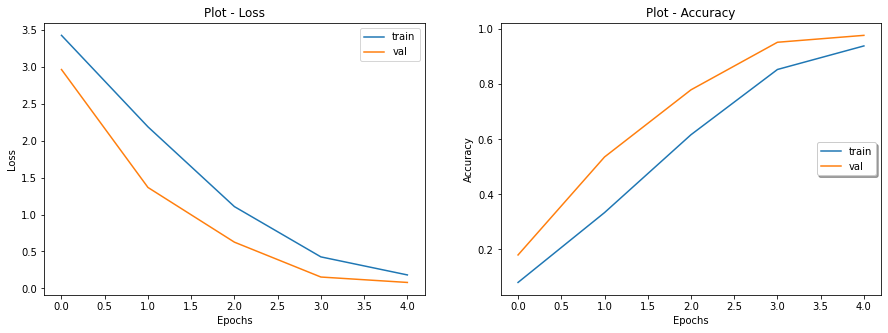

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axs[0].plot(train_loss_list, label="train")
axs[0].plot(val_loss_list, label="val")
axs[0].set_title("Plot - Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
legend = axs[0].legend(loc='upper right', shadow=False)

# Accuracy plot
axs[1].plot(train_acc_list, label="train")
axs[1].plot(val_acc_list, label="val")
axs[1].set_title("Plot - Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
legend = axs[1].legend(loc='center right', shadow=True)

In [ ]:
test_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
    ])

In [ ]:
test_data_path = '/content/drive/MyDrive/Datasets/ML/Test'
test_data = torchvision.datasets.ImageFolder(root = test_data_path, transform = test_transforms)
test_loader = data.DataLoader(test_data, batch_size=1, shuffle=False)

In [ ]:
numClasses = 43

In [ ]:
num = range(numClasses)
labels = []
for i in num:
    labels.append(str(i))
labels = sorted(labels)
for i in num:
    labels[i] = int(labels[i])
print("List of labels : ")
print("Actual labels \t--> Class in PyTorch")
for i in num:
    print("\t%d \t--> \t%d" % (labels[i], i))

List of labels : 
Actual labels 	--> Class in PyTorch
	0 	--> 	0
	1 	--> 	1
	10 	--> 	2
	11 	--> 	3
	12 	--> 	4
	13 	--> 	5
	14 	--> 	6
	15 	--> 	7
	16 	--> 	8
	17 	--> 	9
	18 	--> 	10
	19 	--> 	11
	2 	--> 	12
	20 	--> 	13
	21 	--> 	14
	22 	--> 	15
	23 	--> 	16
	24 	--> 	17
	25 	--> 	18
	26 	--> 	19
	27 	--> 	20
	28 	--> 	21
	29 	--> 	22
	3 	--> 	23
	30 	--> 	24
	31 	--> 	25
	32 	--> 	26
	33 	--> 	27
	34 	--> 	28
	35 	--> 	29
	36 	--> 	30
	37 	--> 	31
	38 	--> 	32
	39 	--> 	33
	4 	--> 	34
	40 	--> 	35
	41 	--> 	36
	42 	--> 	37
	5 	--> 	38
	6 	--> 	39
	7 	--> 	40
	8 	--> 	41
	9 	--> 	42


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/ML/Test.csv')
numExamples = len(df)
labels_list = list(df.ClassId)

In [ ]:
y_pred_list = []
corr_classified = 0

with torch.no_grad():
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    i = 0
    count = 0

    for image, _ in test_loader:
        image=image.to(device)
        count = count+1
        print(count)


        y_test_pred = model(image)

        y_pred_softmax = torch.log_softmax(y_test_pred[0], dim=1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
        y_pred_tags = y_pred_tags.cpu().numpy()
        
        y_pred = y_pred_tags[0]
        y_pred = labels[y_pred]
        
        y_pred_list.append(y_pred)
        
        if labels_list[i] == y_pred:
            corr_classified += 1

        i += 1

print("Number of correctly classified images = %d" % corr_classified)
print("Number of incorrectly classified images = %d" % (numExamples - corr_classified))
print("Final accuracy = %f" % (corr_classified / numExamples))

Streaming output truncated to the last 5000 lines.
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741
7742
7743
7744
7745
7746
7747
7748
7749
7750
7751
7752
7753
7754
7755
7756
7757
7758
7759
7760
7761
7762
7763
7764
7765
7766
7767
7768
7769
7770
7771
7772
7773
7774
7775
7776
7777
7778
7779
7780
7781
7782
7783
7784
7785
7786
7787
7788
7789
7790
7791
7792
7793
7794
7795
7796
7797
7798
7799
7800
7801
7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813
7814
7815
7816
7817
7818
7819
7820
7821
7822
7823

In [ ]:
from PIL import Image


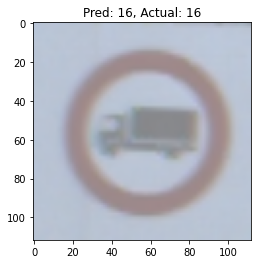

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Pred: %d, Actual: %d" % (y_pred_list[i], labels_list[i]))
    plt.show()


#Get some random training images
dataiter = iter(test_loader)
images, labels = dataiter.next()

#Show images
imshow(torchvision.utils.make_grid(images))
# print labels

